# The user should input: the star's effective temperature (and uncertainty), the event ID (KIC ID), the index number and the max and min freq as seen by eye

In [1]:
Teff_star=6800  #star's temp
Teff_star_uncertainty = 65  #uncertainty of temp

event_id = '11615890'
cadence_condition = 'long'

b =0 #index for tpf and lightcurve

#the index of the tpf and lightcurve. #change manually or implement a loop through every single value then put it in a table)

In [2]:
#importing relevant libraries (use conda install if you don't have them)

import lightkurve as lk
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import matplotlib
plt.style.use(lk.MPLSTYLE)
matplotlib.rcParams['text.usetex'] = False
import scipy.optimize as op
import sympy as smp
from sympy import symbols
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import optimize

# Getting tpf and light curve for each quarter

In [3]:
search_result = lk.search_lightcurve(event_id,cadence=cadence_condition)
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 00,2009,Kepler,1800,kplr011615890,0.0
1,Kepler Quarter 01,2009,Kepler,1800,kplr011615890,0.0
2,Kepler Quarter 02,2009,Kepler,1800,kplr011615890,0.0
3,Kepler Quarter 03,2009,Kepler,1800,kplr011615890,0.0
4,Kepler Quarter 04,2010,Kepler,1800,kplr011615890,0.0
5,Kepler Quarter 05,2010,Kepler,1800,kplr011615890,0.0
...,...,...,...,...,...,...
13,Kepler Quarter 13,2012,Kepler,1800,kplr011615890,0.0
14,Kepler Quarter 14,2012,Kepler,1800,kplr011615890,0.0


array([<AxesSubplot:title={'center':'Target ID: 11615890, Cadence: 568'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>,
       <AxesSubplot:title={'center':'Target ID: 11615890, Cadence: 1105'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>,
       <AxesSubplot:title={'center':'Target ID: 11615890, Cadence: 2977'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>,
       <AxesSubplot:title={'center':'Target ID: 11615890, Cadence: 7404'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>,
       <AxesSubplot:title={'center':'Target ID: 11615890, Cadence: 11914'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>,
       <AxesSubplot:title={'center':'Target ID: 11615890, Cadence: 16373'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>,
       <AxesSubplot:title={'center':'Target ID: 11615890, Cadence: 21070'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>,
       <AxesSubplot:title={'center':'Target ID: 11615890, Cadence: 

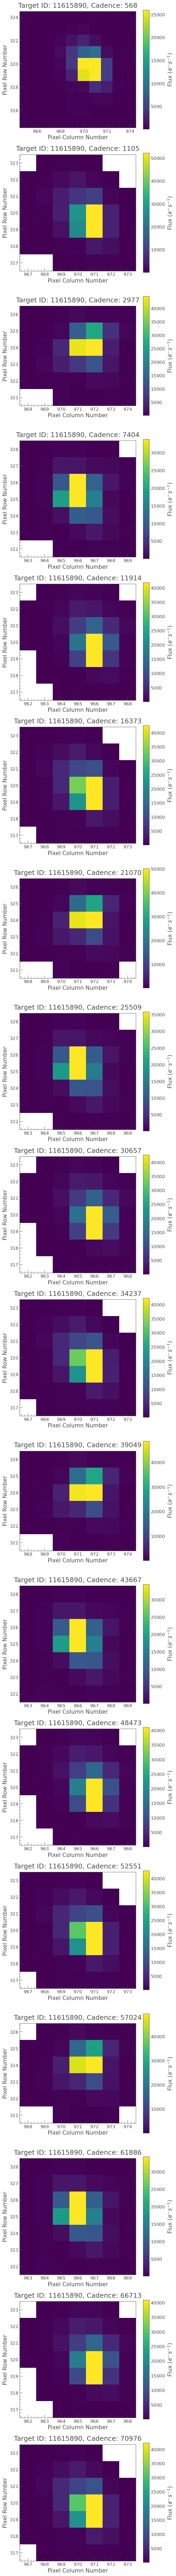

In [4]:
#remember to change the quarter depending on what you see in the table above

tpf = lk.search_targetpixelfile(event_id, author="Kepler", cadence=cadence_condition,quarter=(range(0,19))).download_all(quality_bitmask="hard")
tpf.plot()






<AxesSubplot:title={'center':'Target ID: 11615890, Cadence: 568'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

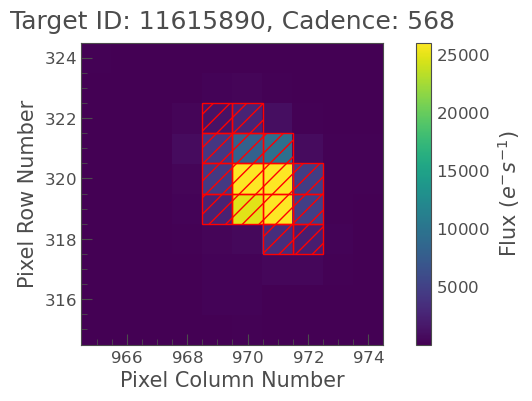

In [5]:
#Plotting the one we are considering
tpf[b].plot(aperture_mask='pipeline')


### in some cases, be sure you're not including a background star. 
#Some cutting method might need to be implemented depending on the star

In [20]:
type(tpf)

lightkurve.collections.TargetPixelFileCollection

In [22]:
#lc = tpf.to_lightcurve(aperture_mask="pipeline").remove_nans().remove_outliers()
#lc.normalize().plot()

lc = []
for m in range(len(tpf)):
    lc.append(tpf[m].to_lightcurve(aperture_mask="pipeline").remove_nans().remove_outliers())


<AxesSubplot:xlabel='Frequency [$\\mathrm{\\mu Hz}$]', ylabel='Signal to Noise Ratio (SNR)'>

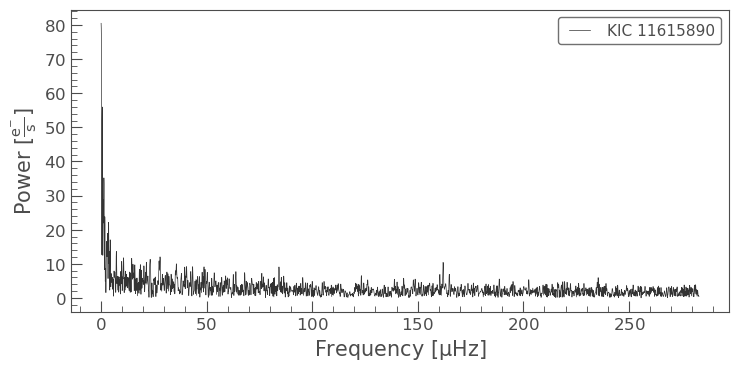

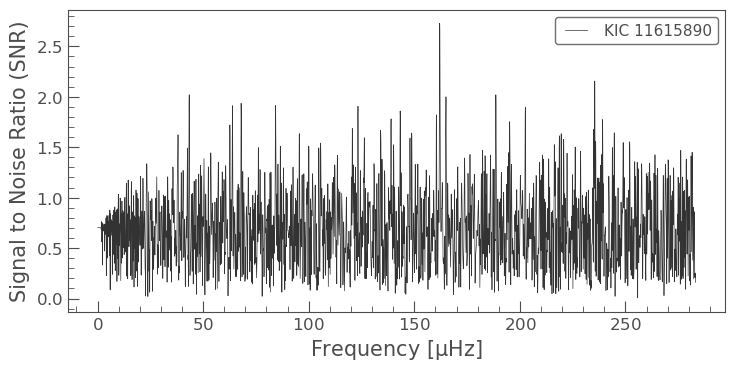

In [11]:

pg = lc[17].to_periodogram(freq_unit = u.microhertz)
pg.plot()
snr = pg.flatten()
snr.plot()

In [ ]:
#lc_collection = search_result.download_all()
#lc= lc_collection.stitch()

#not really necessary for 1 quarter. Need to stich for multiple quarters 

# Finding the zoom in region by eye (use all quarters for this part)

In [7]:
import warnings
warnings.filterwarnings('ignore')




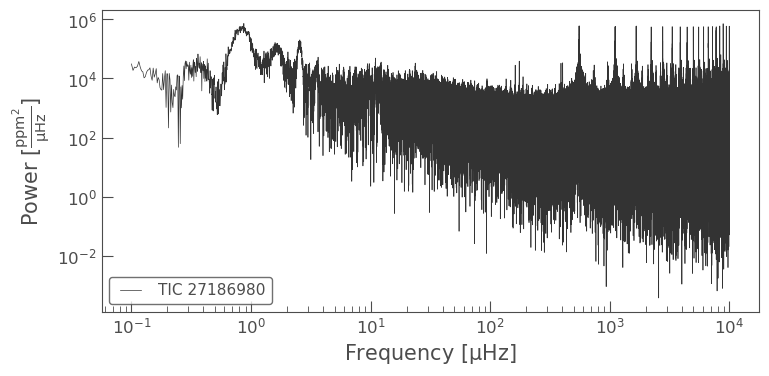

In [8]:
lc_collection = search_result.download_all()
lc_stitched = lc_collection.stitch()
pg1 = lc_stitched.normalize(unit='ppm').to_periodogram(normalization='psd',minimum_frequency = 10**(-1),maximum_frequency=10**4)
pg1.plot(scale='log');
#NOT the same lc!

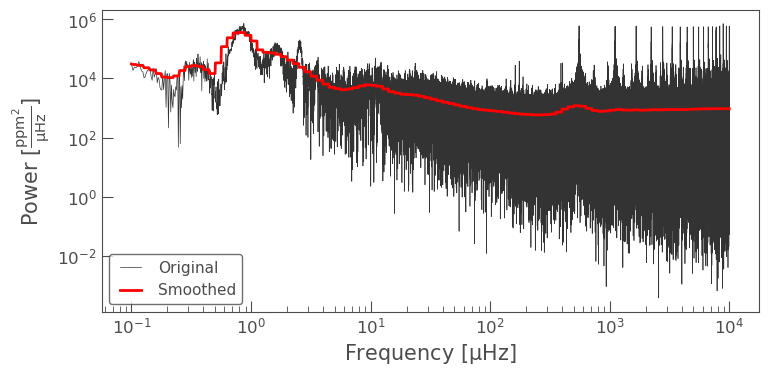

In [9]:
smooth_pg1 = pg1.smooth(method='logmedian', filter_width=0.1)
ax = pg1.plot(label='Original')
smooth_pg1.plot(ax=ax, linewidth=2,  color='red', label='Smoothed', scale='log');


# Defining all the functions

def ACF(power, frequency_spacing, numax):
    #Calculate a full width half maximum
    
    fwhm = int(np.floor(1.0 * 0.25* numax / frequency_spacing))
    fwhm -= fwhm % 2                                    # Make the FWHM value even (%2 = 0 if even, 1 if odd)

    x = int(numax / frequency_spacing)                  #Find the index value of numax
    s = np.hanning(len(snr.power[x-fwhm:x+fwhm]))   #Define the hanning window for the evaluated frequency space
    
    C = snr.power[x-fwhm:x+fwhm] * s                     #Multiply the evaluated SNR space by the hanning window
    if len(C)!= 0:
        result = np.correlate(C, C, mode='full')
        return result[int(len(result)/2):]
    #return result[int(len(result)/2):]
    else: 
        Y=zeros(1,len(C))
        result = np.correlate(Y, Y, mode='full')
        return result[int(len(result)/2):]
    #if len(C)!= 0:
    
    #result = np.correlate(C, C, mode='full')
    #return result[int(len(result)/2):]
    #else: 
        #pass #returns None (type None)

In [10]:
def ACF(power, frequency_spacing, numax):
    #Calculate a full width half maximum
    
    fwhm = int(np.floor(1.0 * 0.25* numax / frequency_spacing))
    fwhm -= fwhm % 2                                    # Make the FWHM value even (%2 = 0 if even, 1 if odd)

    x = int(numax / frequency_spacing)                  #Find the index value of numax
    s = np.hanning(len(snr.power[x-fwhm:x+fwhm]))   #Define the hanning window for the evaluated frequency space
    
    C = snr.power[x-fwhm:x+fwhm] * s                     #Multiply the evaluated SNR space by the hanning window
    result = np.correlate(C, C, mode='full')
    return result[int(len(result)/2):]

In [11]:
def max_acfspace(frequency_spacing, numaxs):
    maxval = numaxs.max()
    fwhm = int(np.floor(1.0 * 0.66 * maxval**0.88 / frequency_spacing))
    fwhm -= fwhm % 2
    return int(2*fwhm)

In [12]:
def fit_func(x, a, x0, sigma,m,c):
    gaus = a*np.exp(-(x-x0)**2/(2*sigma**2))
    line =m*x+c
    return gaus + line

In [13]:
from scipy.signal import find_peaks


def closest_value(input_list, input_value):
 
  arr = np.asarray(input_list)
 
  i = (np.abs(arr - input_value)).argmin()
 
  return arr[i]


In [14]:
## specifying the range of freq interested

freq_min =750

freq_max =1050

###### _________________________________________

In [29]:

print(len(snr.power[x-fwhm:x+fwhm]))
print(np.hanning(641))

NameError: name 'x' is not defined

In [6]:

data=[0,1,2,3,4,5,6,7]
print(data[0:5])

[0, 1, 2, 3, 4]


       time            flux          flux_err      ... cadenceno quality
                   electron / s    electron / s    ...                  
------------------ ------------ ------------------ ... --------- -------
120.53928399252618    4316739.5  51.93069076538086 ...       568       0
 120.5597182572601    4316813.5 51.930320739746094 ...       569       0
120.58015242187685    4316639.0 51.929298400878906 ...       570       0
120.60058678648784    4316392.0   51.9293098449707 ...       571       0
120.62102105110534    4316691.0   51.9317512512207 ...       572       0
120.64145521560567    4316656.0 51.931026458740234 ...       573       0
               ...          ...                ... ...       ...     ...
130.08207834688073    4316978.5  51.93098831176758 ...      1035       0
130.12294681988715    4317159.0 51.930965423583984 ...      1037       0
130.14338105620845    4317048.0 51.930240631103516 ...      1038       0
 130.1638153925378    4317113.5 51.932044982910156 

NameError: name 'numax' is not defined

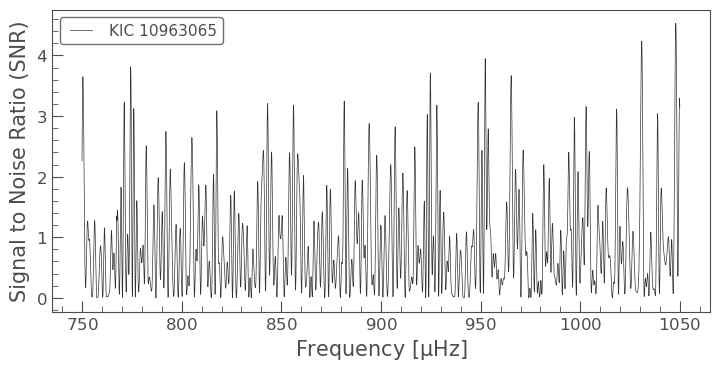

In [31]:
print(lc[0])
pg = lc[0].to_periodogram(freq_unit = u.microhertz,normalization="psd",oversample_factor=10,minimum_frequency=freq_min,maximum_frequency=freq_max)
snr = pg.flatten()
snr.plot()   
frequency_spacing = np.median(np.diff(snr.frequency)).value

# numax calculation ---------
numaxs = np.exp(np.linspace(np.log(10),np.log(snr.nyquist.value),200)) #x axis of the frequency and max correlation graph 
maxacf = np.zeros(len(numaxs))
maxspace = max_acfspace(frequency_spacing, numaxs)
ACF_list = np.zeros((len(numaxs),maxspace))
power = snr.power.value
print(power)
print( ACF(power, frequency_spacing, numax))


# Automated loop

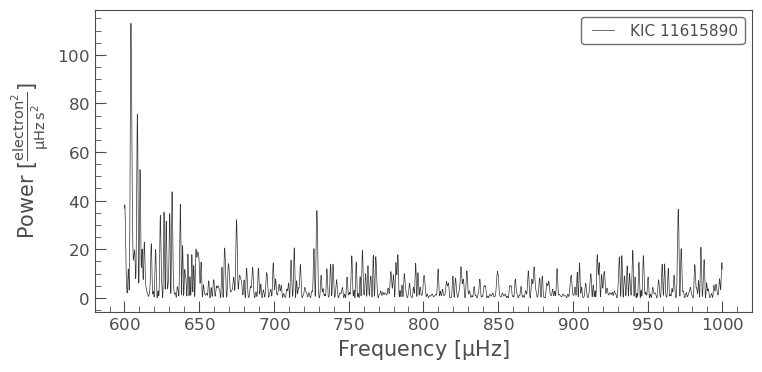

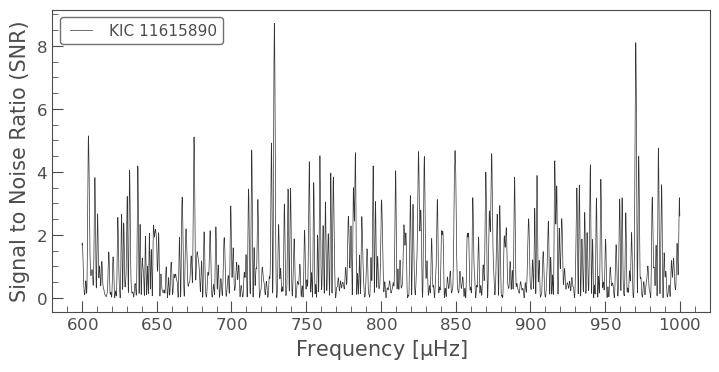

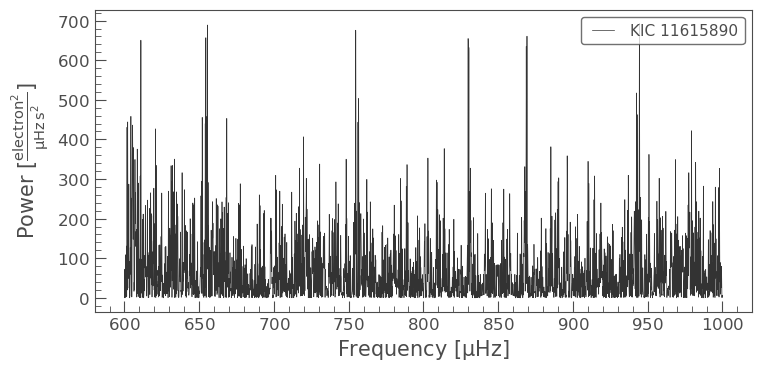

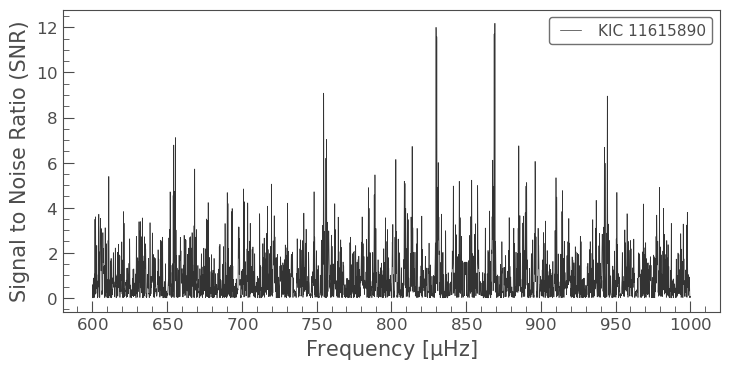

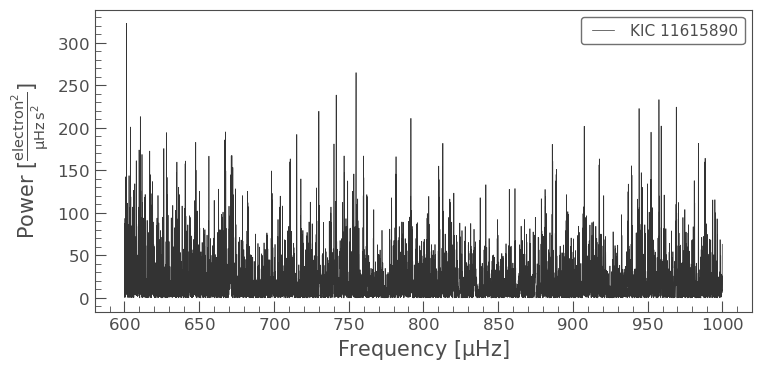

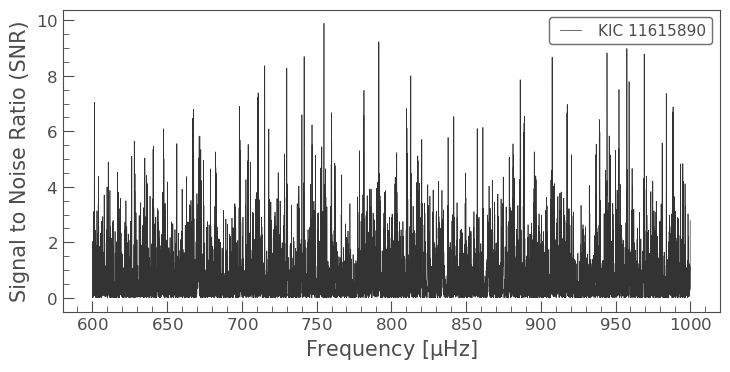

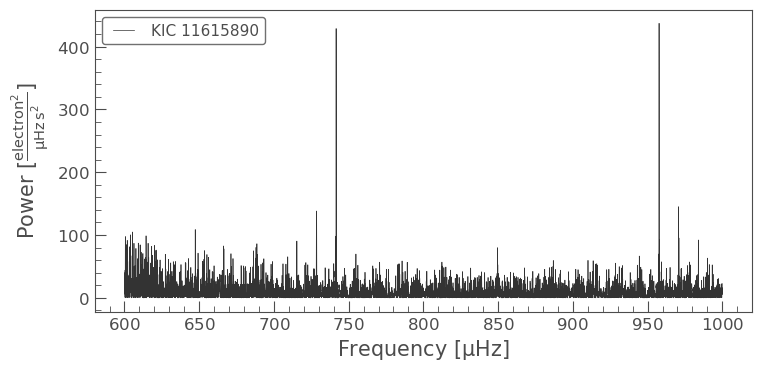

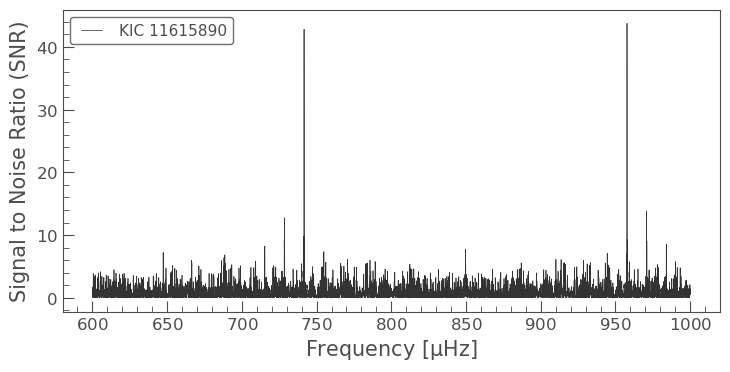

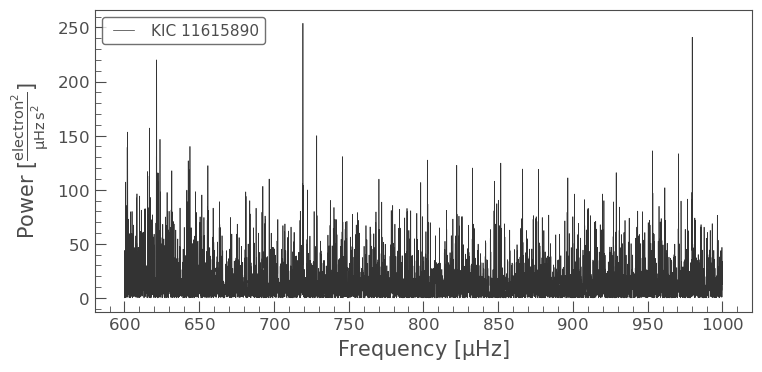

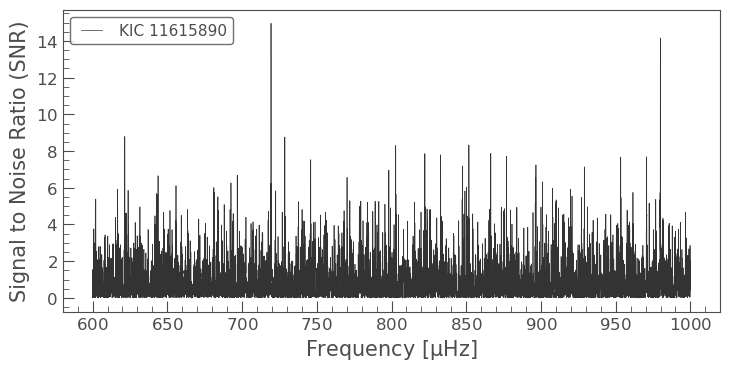

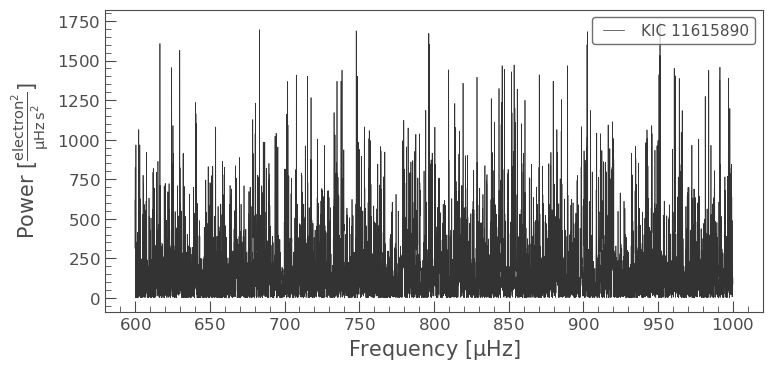

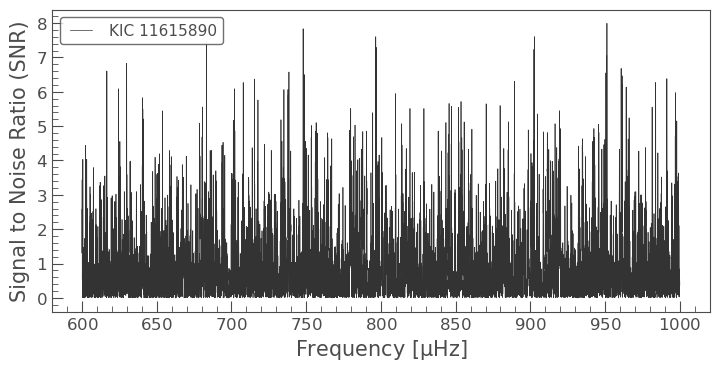

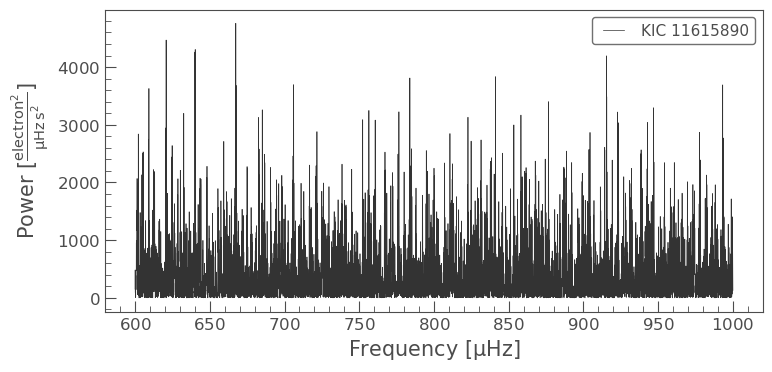

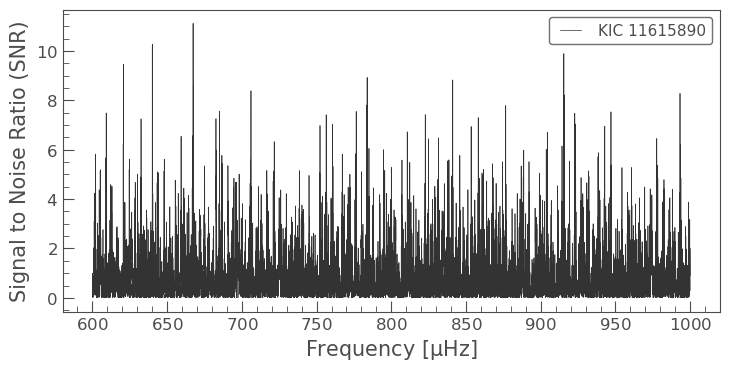

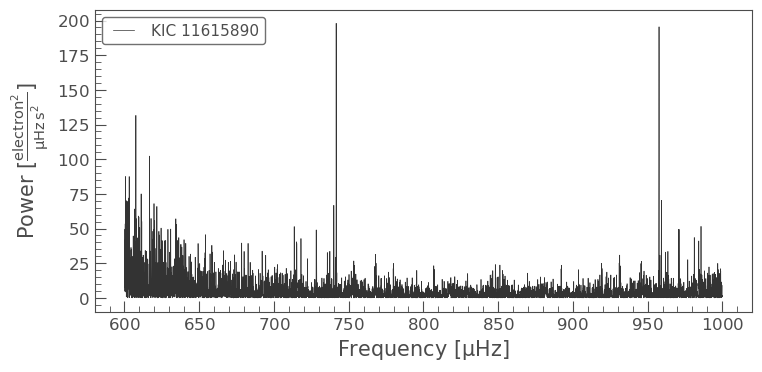

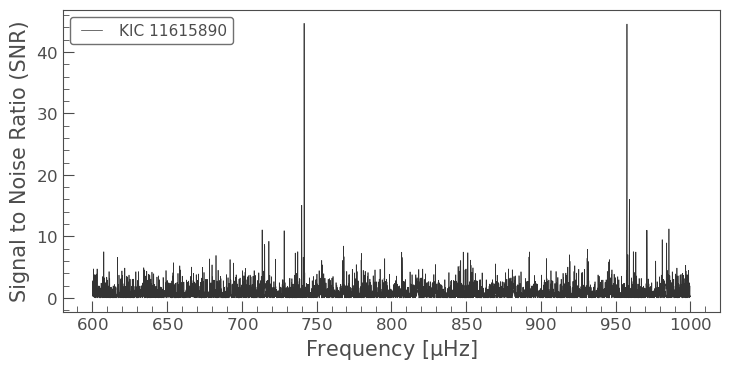

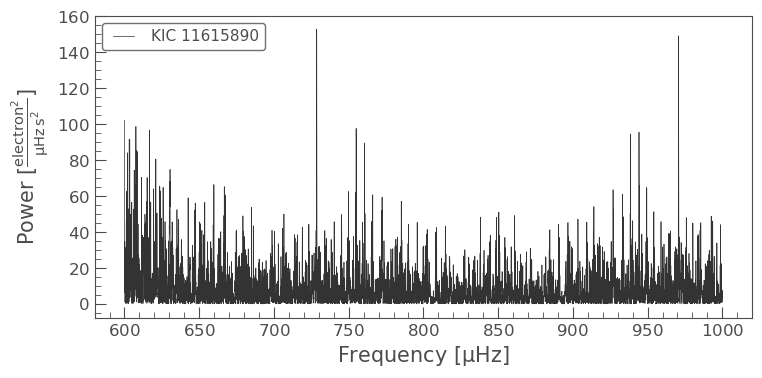

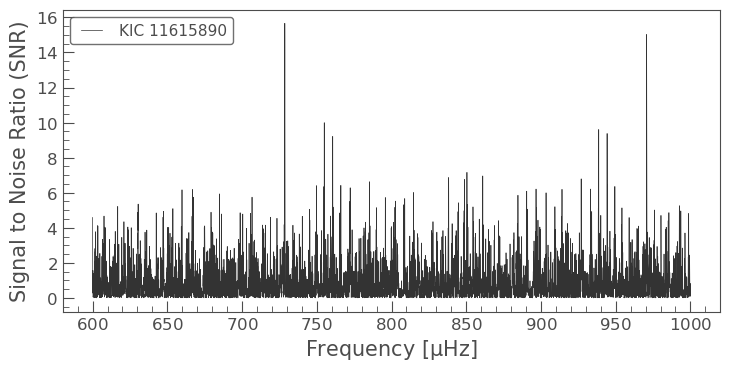

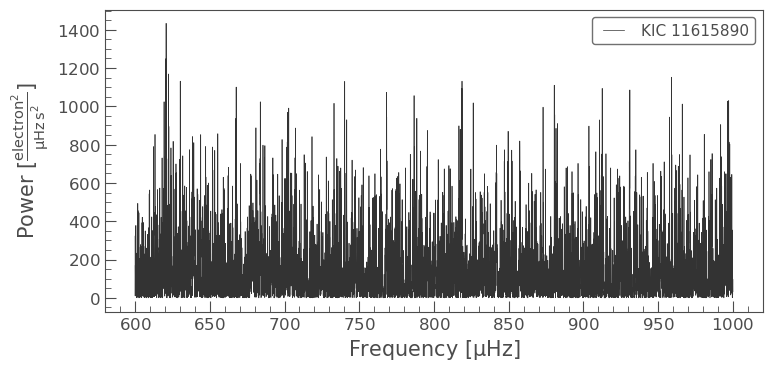

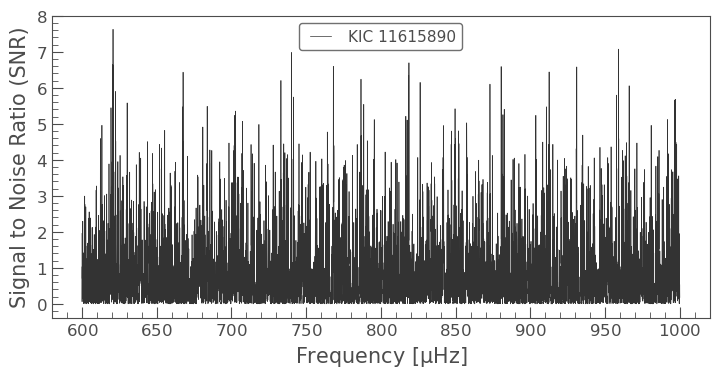

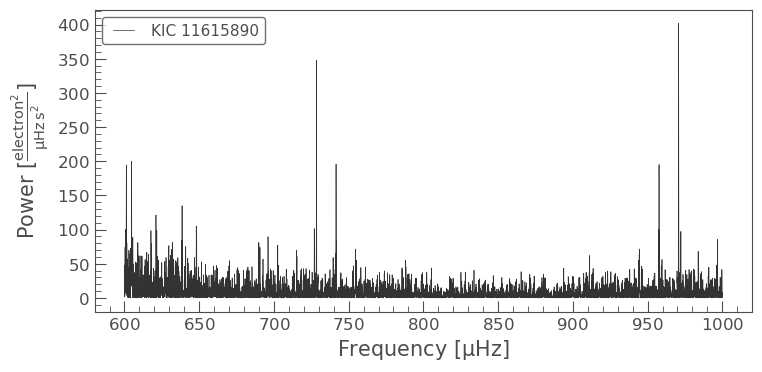

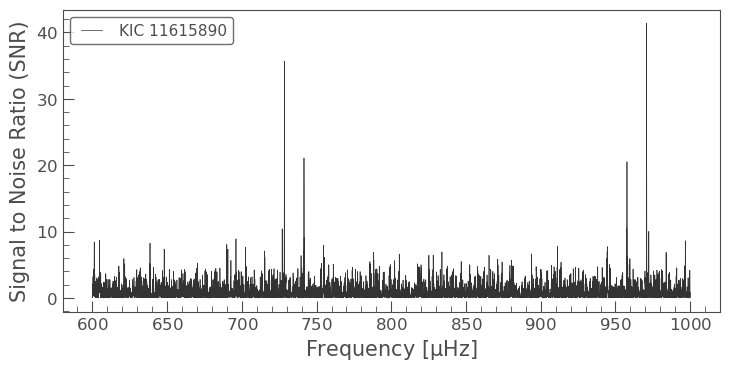

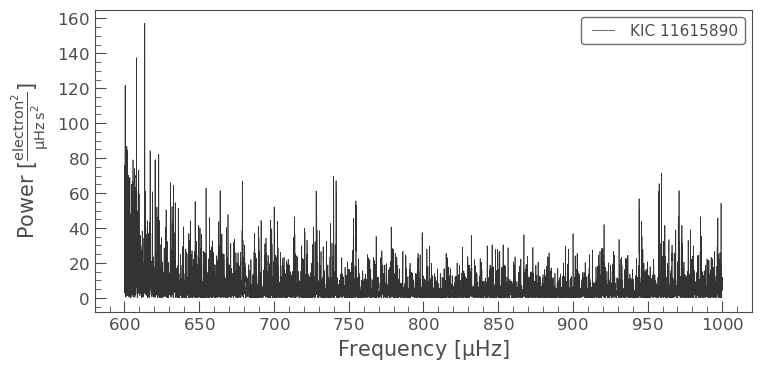

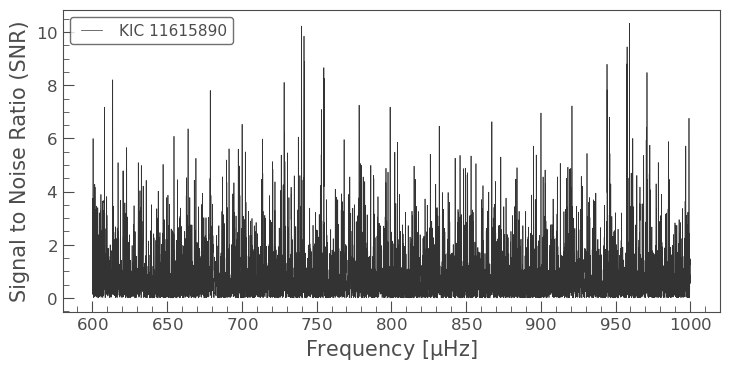

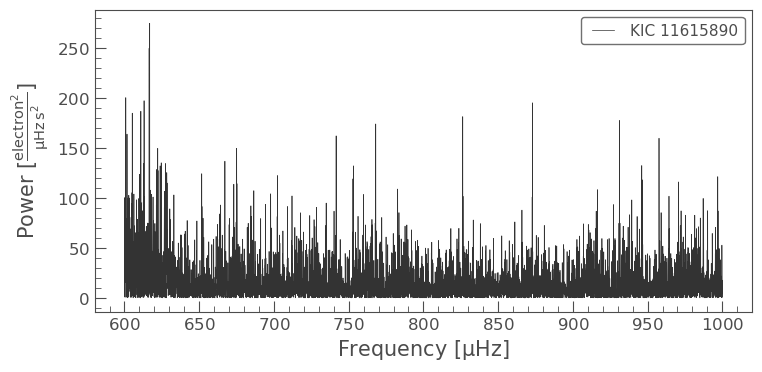

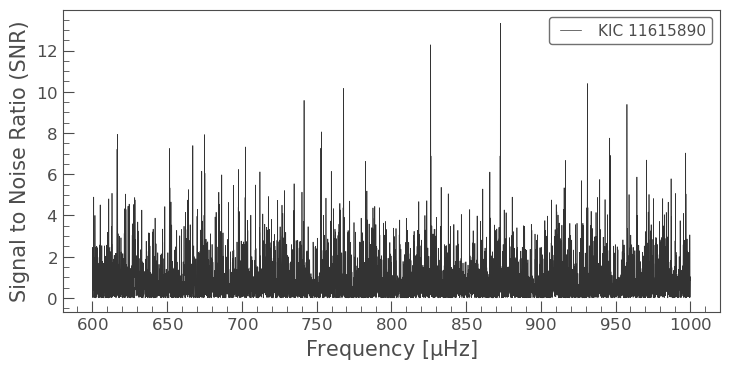

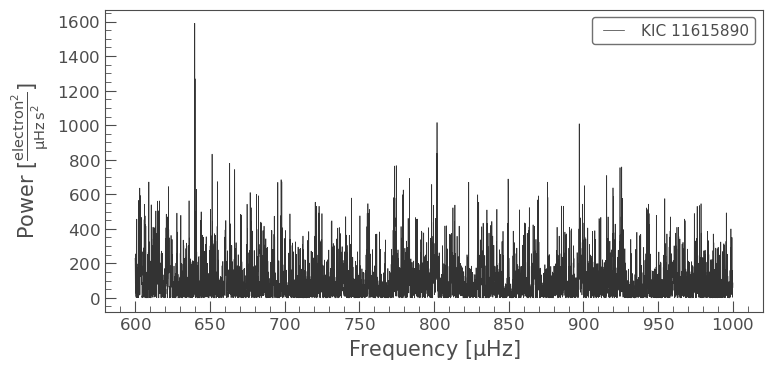

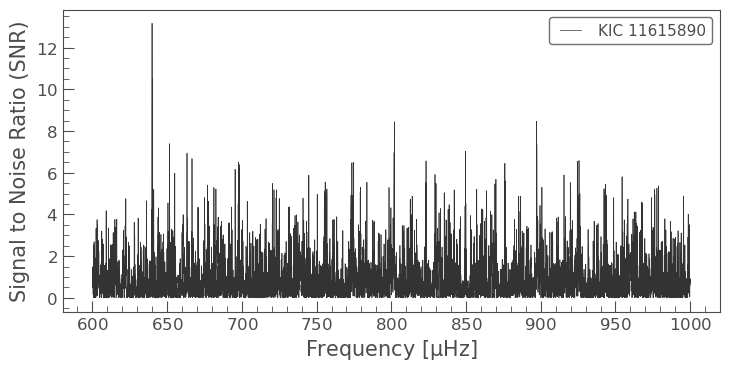

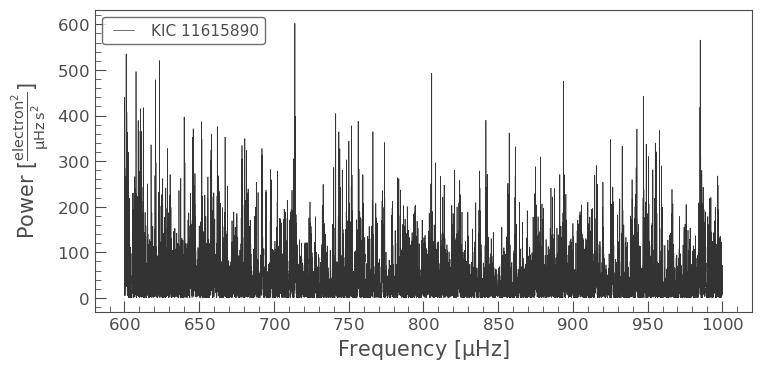

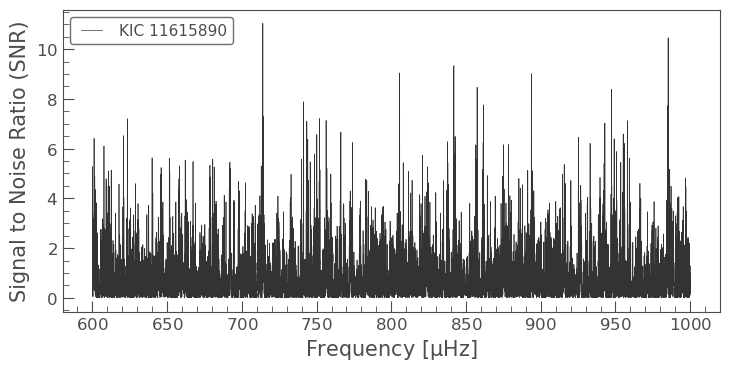

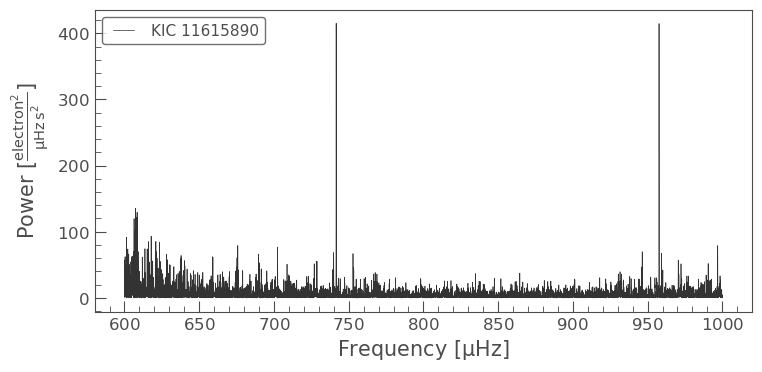

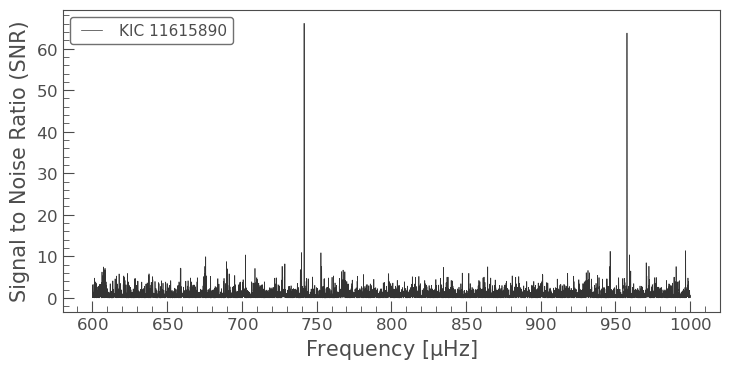

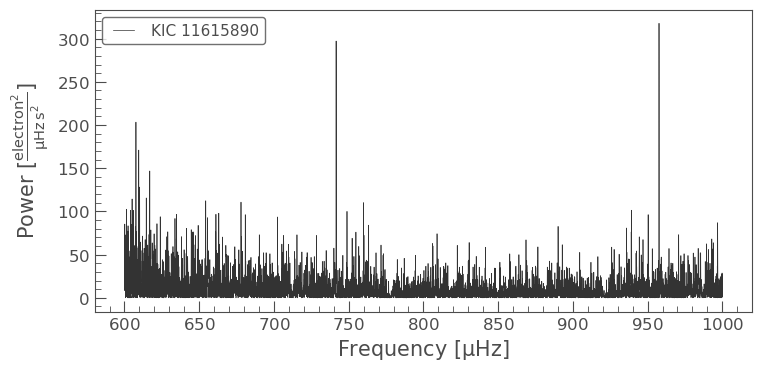

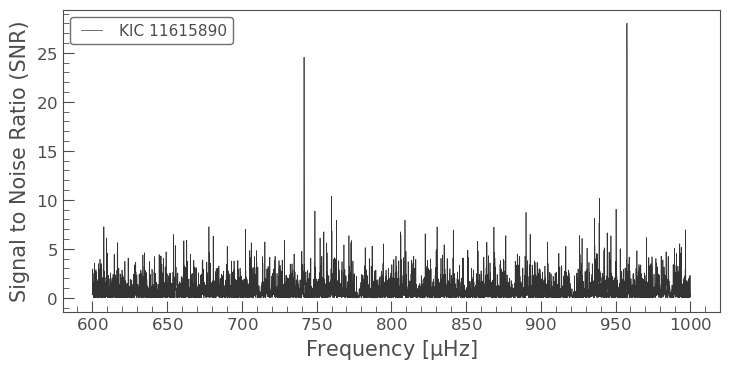

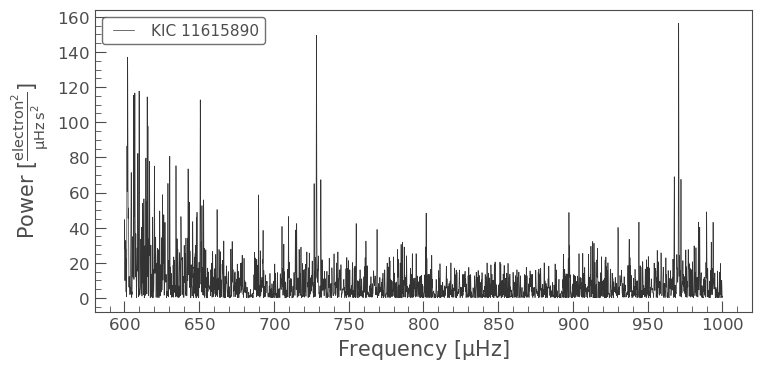

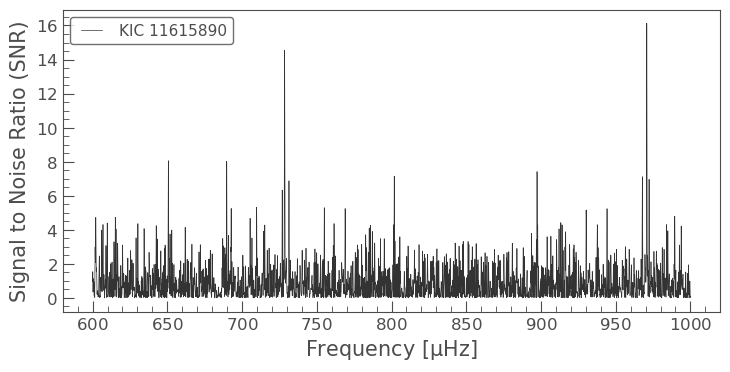

In [26]:
numax_calculated=[]
numax_calculated_uncertainty =[]
deltanu_calculated=[]
deltanu_calculated_uncertainty =[]
diagnostic_percentage_numax =[] #return the percentage
diagnostic_numax=[] #true or false
diagnostic_percentage_deltanu =[]
diagnostic_deltanu =[]

datalist = lk.search_lightcurve('KIC11615890')
data = datalist.download_all()


for e in range (len(tpf)):
    
    #creating periodogram --------
    pg = lc[e].to_periodogram(freq_unit = u.microhertz,normalization="psd",oversample_factor=10,minimum_frequency=600,maximum_frequency=1000)
    pg.plot()
    snr = pg.flatten()
    snr.plot()
    frequency_spacing = np.median(np.diff(snr.frequency)).value

    # numax calculation ---------
    # numax calculation ---------
    numaxs = np.exp(np.linspace(np.log(10),np.log(snr.nyquist.value),200)) #x axis of the frequency and max correlation graph 
    maxacf = np.zeros(len(numaxs))
    maxspace = max_acfspace(frequency_spacing, numaxs)
    ACF_list = np.zeros((len(numaxs),maxspace))
    power = snr.power.value
    for idx, numax in enumerate(numaxs):
        acf = ACF(power, frequency_spacing, numax)    #Calculate the ACF for a given numax
        ACF_list[idx,:len(acf)] = acf/len(acf)
        sum_acf = np.sum(ACF_list[idx,:len(acf)])
        maxacf[idx] = np.nanmax(acf) 
    best_numax = numaxs[np.argmax(maxacf)]     #The best numax is the numax that results in the highest ACF
    #Gaussian fitting ----------
    
    #estimate the initial condition
    a_guess = np.max(maxacf)
    x0_guess = np.mean(numaxs)
    sd_guess = np.std(numaxs)
    m_guess,c_guess = np.polyfit(numaxs,maxacf,1)
    popt, cov_phase = curve_fit(fit_func, numaxs, maxacf, p0 = [a_guess, x0_guess, sd_guess,m_guess,c_guess])
    
        
    #Calculating uncertainty
    x, a, mu, sigma, m, c= symbols('x, a, mu, sigma, m, c ')
    gaussian_plus_line  = a*smp.exp(-(x-mu)**2/(2*sigma**2))+ m*x+c
    derivative = smp.diff(gaussian_plus_line,x)
    eq1 = smp.Eq(derivative,0)
    numaxs_new = np.linspace(np.min(numaxs),np.max(numaxs),10000)
    numax_guess = numaxs_new[np.argmax(fit_func(numaxs_new, *popt))] 
    derivative_with_values = eq1.evalf(subs={a: popt[0] , mu: popt[1], 
                                                            
                                            sigma: popt[2], m: popt[3]})

    from sympy.utilities.lambdify import lambdify
    derivative_with_values_calculate = lambdify(x,derivative_with_values)

    numax_graph = op.fsolve(derivative_with_values_calculate,numax_guess)[0]
    numax_calculated.append(numax_graph) #put it into the numax array
    
    
    ###partial deriv -------
    partial_a = smp.idiff(derivative, x,a)
    partial_mu = smp.idiff(derivative, x,mu)
    partial_sigma = smp.idiff(derivative, x,sigma)
    partial_m = smp.idiff(derivative, x,m)
    # ------
    sigma_mu, sigma_a, sigma_sigma, sigma_m = symbols('sigma_mu, sigma_a, sigma_sigma, sigma_m')
    numax_uncertainty_expression = smp.sqrt(
    partial_a**2 * sigma_a**2 + partial_mu**2 * sigma_mu**2 + partial_sigma**2 * sigma_sigma**2
    +partial_m**2 * sigma_m**2)

    uncertainty = np.sqrt(np.diag(cov_phase)) #uncertainty of each fitting parameter via covariance matrix

    numax_uncertainty = numax_uncertainty_expression.evalf(subs={x: numax_graph ,a: popt[0] , mu: popt[1], 
                                                            
                                            sigma: popt[2], m: popt[3], 
                                            sigma_a: uncertainty[0], sigma_mu: uncertainty[1],
                                            sigma_sigma: uncertainty[2], sigma_m: uncertainty [3]}) 
    numax_calculated_uncertainty.append(numax_uncertainty) #append to the numax uncertainty array 
    
    # Diagnostic for numax -------
    threshold_accept = 0.05#we decide that the max difference between the values to be 5% (random)
    percentage_diff_max = np.abs(best_numax-(numax_graph+numax_uncertainty))/best_numax
    percentage_diff_min = np.abs(best_numax-(numax_graph-numax_uncertainty))/best_numax

    if percentage_diff_max<percentage_diff_min:
        percentage_diff = percentage_diff_max
    else: 
        percentage_diff = percentage_diff_min
    
    diagnostic_percentage_numax.append(percentage_diff*100) #appending % diff for numax
    
    if percentage_diff<threshold_accept:
        diagnostic_numax.append('Acceptable')
    else: 
        diagnostic_numax.append('Not acceptable')
        
    
        
    #deltanu stuff ----------
    
    numax = numax_graph

    fwhm = int(np.floor(1.0 * 0.66*0.88 * numax / frequency_spacing))
    fwhm -= fwhm % 2                                    # Make the FWHM value even (%2 = 0 if even, 1 if odd)
    
    x = int(numax / frequency_spacing)                  #Find the index value of numax
    s = np.hanning(len(snr.power[x-fwhm:x+fwhm]))   #Define the hanning window for the evaluated frequency space
 
    C = snr.power[x-fwhm:x+fwhm] * s      
    #C=0
    #Multiply the evaluated SNR space by the hanning window
    result = np.correlate(C, C, mode='full')             #Correlated the resulting SNR space with itself
    acf = result[int(len(result)/2):]    
    lags = np.linspace(0, len(acf)*frequency_spacing, len(acf))

    c_1,c_2,v_max = symbols('c_1,c_2,v_max') 
    delta_nu_expression = c_1*v_max**c_2
    
    partial_c_1 = smp.diff(delta_nu_expression,c_1)
    partial_c_2 = smp.diff(delta_nu_expression, c_2)
    partial_v_max = smp.diff(delta_nu_expression, v_max)

    sigma_c_1, sigma_c_2, sigma_v_max = symbols('sigma_c_1, sigma_c_2, sigma_v_max')
    deltanu_uncertainty_expression = smp.sqrt(
    partial_c_1**2 * sigma_c_1**2 + partial_c_2*2 * sigma_c_2**2 + partial_v_max**2 * sigma_v_max**2)
    deltanu_uncertainty_2 = deltanu_uncertainty_expression.evalf(subs={
    c_1: 0.263, sigma_c_1: 0.009, c_2: 0.772 , sigma_c_2: 0.005, v_max: numax_graph, sigma_v_max: numax_uncertainty}) 
    float(deltanu_uncertainty_2)

    deltanu_empirical_average = 0.263*float(numax_graph)**(0.772)
    newlist_2 = np.linspace(deltanu_empirical_average-float(deltanu_uncertainty_2),
                        deltanu_empirical_average+float(deltanu_uncertainty_2),1000)



    
    # peak finding stuff
    
    peaks,_ = find_peaks(acf, prominence=(0, 10000),distance=3)

    deltanu_2=[]
    for f in range(len(newlist_2)):
        deltanu_2.append(closest_value(lags[peaks],newlist_2[f]))

    deltanu_mean_2 = np.mean(deltanu_2)
    deltanu_sd_2 = 0.5*(np.max(deltanu_2)-np.min(deltanu_2))
    
    deltanu_calculated.append(deltanu_mean_2)
    deltanu_calculated_uncertainty.append(deltanu_sd_2)
    
    if deltanu_sd_2/deltanu_mean_2<0.01:
        diagnostic_deltanu.append('Robust')
        diagnostic_percentage_deltanu.append(deltanu_sd_2/deltanu_mean_2 * 100)
    else:
        diagnostic_deltanu.append('Not robust')
        diagnostic_percentage_deltanu.append(deltanu_sd_2/deltanu_mean_2 * 100)
    deltanu_2=[] #reset back to empty array before looping through the next tpf
    

In [ ]:




print(len(acf))

# Calculating the stellar parameters

In [19]:
#defining the constants
numax_solar = 3090
deltanu_solar = 135.1
Teff_solar = 5777.2


In [24]:
print(numax_calculated)
print(len(tpf))

[283.2019862613635, 283.20235331407366, 283.2093508921018, 143.0717349814788, 283.21239882702633, 283.2026053104275, 283.20973339304015, 159.6306331852698, 283.2128547522605, 283.202732216324, 132.73759892286384, 283.22066203157345, 283.21315073636015, 283.20264312504503, 283.20897817401607, 143.2357192390878, 148.66884118450503, 128.99219865267483]
18


In [17]:
mass =[]
mass_uncertainty=[]

radius=[]
radius_uncertainty =[]

luminosity =[]
luminosity_uncertainty=[]
for y in range (len(tpf)):
    mass_star = (numax_calculated[y]/numax_solar)**3 * (deltanu_calculated[y]/deltanu_solar)**(-4) *(Teff_star/Teff_solar)**1.5
    mass.append(mass_star)
    
    
    ratio1_relative_uncertainty = float((numax_calculated_uncertainty[y]/numax_calculated[y])*3)
    ratio_2_relative_uncertainty = (deltanu_calculated_uncertainty[y]/deltanu_calculated[y])*4
    ratio_3_relative_uncertainty = (Teff_star_uncertainty/Teff_star)*1.5
    total_relative_uncertainty = np.sqrt(ratio1_relative_uncertainty**2+ratio_2_relative_uncertainty**2+ratio_3_relative_uncertainty**2)
    mass_star_uncertainty = total_relative_uncertainty*mass_star
    mass_uncertainty.append(mass_star_uncertainty)

    radius_star = (numax_calculated[y]/numax_solar) * (deltanu_calculated[y]/deltanu_solar)**(-2) *(Teff_star/Teff_solar)**0.5
    ratio1_relative_uncertainty_radius = float ( (numax_calculated_uncertainty[y]/numax_calculated[y]))
    ratio_2_relative_uncertainty_radius = (deltanu_calculated_uncertainty[y]/deltanu_calculated[y])*2 
    ratio_3_relative_uncertainty_radius = (Teff_star_uncertainty/Teff_star)*0.5

    total_relative_uncertainty_radius = np.sqrt(ratio1_relative_uncertainty_radius**2
                                            +ratio_2_relative_uncertainty_radius**2+
                                            ratio_3_relative_uncertainty_radius**2)
    
    radius_star_uncertainty = total_relative_uncertainty_radius*radius_star
    radius.append(radius_star)
    radius_uncertainty.append(radius_star_uncertainty)

    L = radius_star**2 * (Teff_star/Teff_solar)**4
    L_uncertainty = L*np.sqrt((2*total_relative_uncertainty_radius)**2 + (Teff_star_uncertainty*4/Teff_star)**2)
    
    luminosity.append(L)
    luminosity_uncertainty.append(L_uncertainty)
    
    

In [25]:
numax_mean = np.mean(numax_calculated)
print(numax_mean)

236.37978751108292


# Summarizing results

In [19]:
numax_mean = np.mean(numax_calculated)
numax_error = np.std(numax_calculated)/len(numax_calculated)

deltanu_mean_value = np.mean(deltanu_calculated) 
deltanu_error = np.std(deltanu_calculated)/len(deltanu_calculated)


mass_mean = np.mean(mass)
mass_error = np.std(mass)/len(mass)


radius_mean = np.mean(radius)
radius_error = np.std(radius)/len(radius)

luminosity_mean = np.mean(luminosity)
luminosity_error = np.std(luminosity)/len(luminosity)


print('numax:',round(numax_mean,2), '±', round(numax_error,2))
print('delta nu:',round(deltanu_mean_value,2), '±', round(deltanu_error,2))
print('mass:',round(mass_mean,2), '±', round(mass_error,2))
print('radius:',round(radius_mean,2), '±', round(radius_error,2))
print('luminosity:',round(luminosity_mean,2), '±', round(luminosity_error,2))
print('number of tpf used:',len(tpf))

numax: 67.02 ± 0.0
delta nu: 6.89 ± 0.02
mass: 1.95 ± 0.02
radius: 9.09 ± 0.04
luminosity: 159.1 ± 1.4
number of tpf used: 14


# Freq in microHertz, all stellar parameters are in solar units